In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.animation import FuncAnimation
from scipy.signal import hilbert
import matplotlib.colors
from nilearn import plotting
from tqdm import tqdm
import matplotlib.ticker as tkr

### Read regions position data

In [2]:
data_frame_ = pd.read_csv("schaefer_200_tian-subcortex_16.csv", header=0)
data_frame_ = data_frame_.iloc[:200, 2:5]  # Select only the three position columns
pos = data_frame_.values  # Convert to NumPy array

### Read file and compute $A$ matrix

In [3]:
df = pd.read_csv('hcp_MEG_connectomes/100307_sc.csv', header=0, usecols=range(216),  dtype=float)

sub = df.iloc[:200, :200]
binary = (sub != 0).astype(int)
A_bin = binary.values  # shape (200, 200), dtype=int
np.fill_diagonal(A_bin, A_bin.diagonal() + 1)
eigenvalues = np.linalg.eigvals(A_bin)
max_eig = np.max(np.real(eigenvalues))
A = A_bin/ max_eig # normalize by largest eigenvalue

### Define the functions for the system

In [4]:
def S(x):
    return np.tanh(x)

def network_rhs(t, y, A, tau_E, tau_I, wEE, wEI, wIE, wII, P_E, P_I):
    N = A.shape[0]

    # Ensure y is 2D for vectorized=True support
    if y.ndim == 1:
        y = y[:, np.newaxis]  # shape becomes (2N, 1)

    E = y[:N, :]  # shape (N, k)
    I = y[N:, :]  # shape (N, k)

    # Compute inputs
    inp_E = wEE * A @ E - wEI * I + P_E  # shape (N, k)
    inp_I = wIE * A @ E - wII * I + P_I  # shape (N, k)

    # Nonlinear outputs
    H_E = np.tanh(inp_E)
    H_I = np.tanh(inp_I)

    dE = (-E + H_E) / tau_E
    dI = (-I + H_I) / tau_I

    # Return shape must be (2N, k)
    return np.vstack([dE, dI])


In [5]:
from functools import partial
from joblib import Parallel, delayed
from itertools import product

In [6]:
E0 = np.zeros((200)) # create empty array for exitatory
I0 = np.zeros((200)) # create empty array for inhibitory

y0 = np.concatenate([E0, I0])

t0, t1 = 0.0, 75     # start and end times
t_eval = np.linspace(t0, t1, 501)

# Time constants
tau_E = 1
tau_I = 1

# Synaptic weights
wEE, wEI = 2, 10
wIE, wII = 10, 1.0

wEI, wII = 10, 1  # Fixed inhibitory parameters
wEE_values = np.linspace(0.1, 40, 300)
wIE_values = np.linspace(0.1, 20, 150)

r_mean = np.zeros((len(wEE_values), len(wIE_values))) # create empty array for synchrony measure

# External inputs (can be scalars or arrays of shape (N,))
P_E = 1
P_I = 1

def wrapped_rhs(t, y, wEE, wIE):
    return network_rhs(t, y, A, tau_E, tau_I, wEE, wEI, wIE, wII, P_E, P_I)

def compute_r_mean(wEE, wIE):
    sol = solve_ivp(lambda t, y: wrapped_rhs(t, y, wEE, wIE),
                    t_span=(t0, t1), y0=y0, t_eval=t_eval, method='RK45', vectorized=True)

    E_t = sol.y[:200, :]
    analytic_signal = hilbert(E_t, axis=1)
    phase = np.angle(analytic_signal)
    z = np.mean(np.exp(1j * phase), axis=0)
    r = np.abs(z)
    return np.mean(r)

# Create grid of parameters
param_grid = list(product(wEE_values, wIE_values))

# Parallel execution
r_mean_flat = Parallel(n_jobs=-1)(delayed(compute_r_mean)(wEE, wIE) for wEE, wIE in param_grid)

# Reshape to 2D
r_mean = np.array(r_mean_flat).reshape(len(wEE_values), len(wIE_values))

# for i, wEE in tqdm(enumerate(wEE_values)):
#     for j, wIE in enumerate(wIE_values):
#         sol = solve_ivp(fun=network_rhs, t_span=(t0, t1), y0=y0, t_eval=t_eval, args=(A, tau_E, tau_I, wEE, wEI, wIE, wII, P_E, P_I), method='RK45', vectorized=False)

#         E_t = sol.y[:200, :]   # shape (N, len(t_eval))
#         I_t = sol.y[200:, :]   # shape (N, len(t_eval))

#         N, T = E_t.shape

#         # 1) Compute analytic signal and instantaneous phase for each node
#         #    axis=1 means we do the transform over time for each row (node)
#         analytic_signal = hilbert(E_t, axis=1)    # shape (N, T)
#         phase = np.angle(analytic_signal)         # φ_j(t)

#         # 2) Compute the complex order parameter at each t
#         #    z(t) = (1/N) * sum_j exp(i φ_j(t))
#         z = np.mean(np.exp(1j * phase), axis=0)   # shape (T,)

#         # 3) Extract magnitude r(t) and mean phase ψ(t)
#         r = np.abs(z)                             # synchrony measure ∈ [0,1]
#         psi = np.angle(z)                         # average phase
        
#         r_mean[i, j] = np.mean(r)  # Store the mean synchrony measure for this parameter combination

In [7]:
X, Y = np.meshgrid(wEE_values, wIE_values, indexing = "ij")  # Create a meshgrid for the parameter space
data = {
    'x': X.flatten(),
    'y': Y.flatten(),
    'value': r_mean.flatten()
}
df = pd.DataFrame(data)
df.to_csv("r_mean_.csv", index=False)

0.9999999966704565


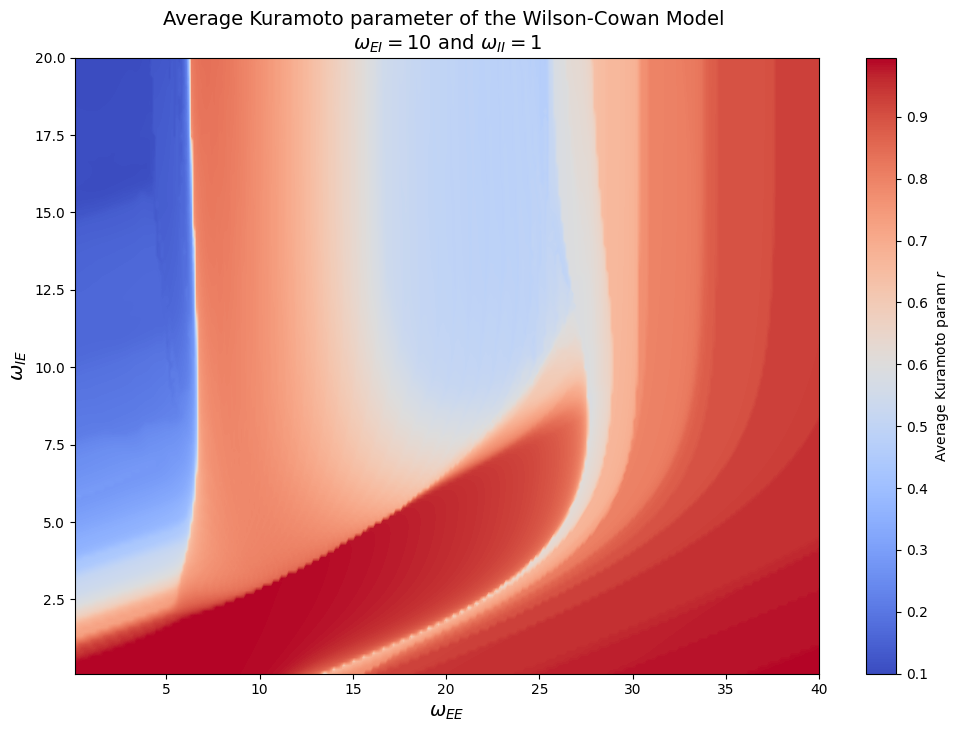

In [8]:
plt.figure(figsize=(12,8))
print(r_mean.max())
clev = np.arange(r_mean.min(),r_mean.max()+0.001,.001)
cs = plt.contourf(wEE_values, wIE_values, r_mean.T, clev, cmap='coolwarm')
plt.colorbar(label=r"Average Kuramoto param $r$", format=tkr.FormatStrFormatter('%.1f'))
plt.xlabel(r"$\omega_{EE}$", fontsize = 14)
plt.ylabel(r"$\omega_{IE}$", fontsize = 14)
plt.title("Average Kuramoto parameter of the Wilson-Cowan Model \n"r"$\omega_{EI} = 10$ and $\omega_{II} = 1$", fontsize = 14)
plt.show()

